In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re

In [2]:
GAMMAS = ['1.0','0.9','0.8','0.7','0.6','0.5']
INDEX_TIME_UNIT = 1000 # number of tweets
QUERY_TIME_UNIT = 1000 # number of tweets
SIMILARITY_THRE = 0.5
NUMBER_OF_RUNS = 3
OUTPUT_DIR = "./output_expm1/"

def get_chance(gamma):
    if gamma == '1.0':
        return '100'
    elif gamma == '0.9':
        return '90'
    elif gamma == '0.8':
        return '80'
    elif gamma == '0.7':
        return '70'
    elif gamma == '0.6':
        return '60'
    elif gamma == '0.5':
        return '50'
    
def get_gamma_index(gamma):
    if gamma == '1.0':
        return 0
    elif gamma == '0.9':
        return 1
    elif gamma == '0.8':
        return 2
    elif gamma == '0.7':
        return 3
    elif gamma == '0.6':
        return 4
    elif gamma == '0.5':
        return 5
    
SUMMARY_INDEX = pd.Index(['Run', 'Chance', 'Index time unit', 'Query time unit', 'Similarity threshold', 
                 'Query counts', 'Indexed tweet counts', 'Index size'])
SUMMARY_COL = ['Summary_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_RESULT_COL = ['Result_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_SIMILARITY_COL = ['Similarity_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_LOOKUPS_COL = ['Lookups_' + get_chance(p) + '%' for p in GAMMAS]
INDEX_TIME_COL = ['Index_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in GAMMAS for i in range(NUMBER_OF_RUNS)]
QUERY_TIME_COL = ['Query_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in GAMMAS for i in range(NUMBER_OF_RUNS)]

FREQ_TABLES_X = ['Posting_list_length_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_RECALL_X = ['Query_recall_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_PRECISION_X = ['Query_precision_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_LESS_LOOKUPS_X = ['Query_of_less_lookups_' + get_chance(p) + '%' for p in GAMMAS]
AVERAGE_LOOKUPS_X = ['Average_lookup_counts_' + get_chance(p) + '%' for p in GAMMAS]
PLOT_X = [get_chance(p) + '%' for p in GAMMAS]

# Run Experiment  One and Read in Results

* Use single terms to construct index
* Each term has a 100% chance to 50% chance to be included in the index or fingerprint

In [3]:
def runSketchTweets(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, n, output_dir):
    for run in range (1, n+1):
        os.system("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
        .format(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, run, output_dir))
#         print("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
#         .format(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, run, output_dir))

In [4]:
# This function runs the experiment and compares the results including:
# - the size of the index and doc lists 
# - time for constructing the index and executing query 
# - number of lookups before finding the match

def run_expm1():
    for p in GAMMAS:
        runSketchTweets("SketchingTweet-v1", INDEX_TIME_UNIT, QUERY_TIME_UNIT, p, SIMILARITY_THRE, NUMBER_OF_RUNS, OUTPUT_DIR)
    results = load_expm1_csv(OUTPUT_DIR)
    return results

In [5]:
def load_expm1_csv(directory):
    '''
    Returns a dictionary of results.
    The dictionary keys are: summary, termfreq, query_results_similarity_lookups, index_time, query_time
    '''
    results = {}
    summary = [0] * len(GAMMAS)
    termfreq = [0] * len(GAMMAS)
    query_result = [0] * len(GAMMAS)
    query_similarity = [0] * len(GAMMAS)
    query_lookups = [0] * len(GAMMAS)
    index_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(GAMMAS))]
    query_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(GAMMAS))]
      

    for root, _, files in os.walk(directory):
        for file in files:
            filename = re.match( r'Epoch_(\d+)_iu_(\d+)_qu_(\d+)_p_(\d+\.\d+)_s_([\.\d]+)_(.+).csv', file)  
#             print(filename.group(3),filename.group(4),filename.group(5),filename.group(6))
            name = filename.group(6)
            gamma = filename.group(4)

            if name == "summary":    
                for p in GAMMAS:
                    if gamma == p:
                        summary[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)

            if name == "term_freq":
                for p in GAMMAS:
                    if gamma == p:
                        termfreq[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_result":
                for p in GAMMAS:
                    if gamma == p:
                        query_result[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_similarity":
                for p in GAMMAS:
                    if gamma == p:
                        query_similarity[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "lookups":
                for p in GAMMAS:
                    if gamma == p:
                        query_lookups[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
            
            if name == "index_time":
                run = filename.group(1)
                for p in GAMMAS:
                    if gamma == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                index_time[get_gamma_index(gamma)][i] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_time":
                run = filename.group(1)
                for p in GAMMAS:
                    if gamma == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                query_time[get_gamma_index(gamma)][i] = pd.read_csv(directory + "/" + file, header=None)
                  
    
    summary = pd.concat(summary, 1)
    summary = summary.set_index(SUMMARY_INDEX)
    summary.columns = SUMMARY_COL
#     print(summary)
    
    for table in termfreq:
        termfreq_index = table.iloc[:,0]
        table.set_index(termfreq_index, inplace=True)
        table.drop(table.columns[0], axis=1, inplace=True)
        table.columns = ['number_of_terms', 'posting_count']
#     print(termfreq)
    
    query_result = pd.concat(query_result, 1)
    query_result.columns = QUERY_RESULT_COL
#     print(query_result)
    
    query_similarity = pd.concat(query_similarity, 1)
    query_similarity.columns = QUERY_SIMILARITY_COL
#     print(query_similarity)

    query_lookups = pd.concat(query_lookups, 1)
    query_lookups.columns = QUERY_LOOKUPS_COL
#     print(query_lookups)

    query_result_similarity_lookup = [query_result, query_similarity, query_lookups]
    query_result_similarity_lookup = pd.concat(query_result_similarity_lookup, 1)
#     print(query_result_similarity_lookup)
    
    index_time_dfs = []
    for p in index_time:
        index_time_df = pd.concat(p, 1)
        index_time_dfs.append(index_time_df)
    index_time = pd.concat(index_time_dfs, 1)
    index_time.columns = INDEX_TIME_COL
    
    query_time_dfs = []
    for p in query_time:
        query_time_df = pd.concat(p, 1)
        query_time_dfs.append(query_time_df)
    query_time = pd.concat(query_time_dfs, 1)
    query_time.columns = QUERY_TIME_COL
    
    results['summary'] = summary
    results['termfreq'] = termfreq
    results['query_result_similarity_lookup'] = query_result_similarity_lookup
    results['index_time'] = index_time
    results['query_time'] = query_time
  
    return results

In [6]:
results = run_expm1() 

# Process Results

In [7]:
def plot_linechart(title, x, y, x_label, y_label, scale='linear'):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_scatter(title, x, y, x_label, y_label, scale='linear'):
    plt.scatter(x, y, s=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_barchart(title, x, y, x_label, y_label, color="#66B3BA"):
    layer = sns.barplot(x=x, y=y, color=color)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def plot_boxplot(title, data, y_label, scale='linear'):
    layer = sns.boxplot(data=data)
    layer = sns.stripplot(data=data, color="orange", jitter=0.2, size=1.5)
    plt.title(title)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()

## Index size comparison

In [8]:
summary = results['summary']
summary

,Summary_100%,Summary_90%,Summary_80%,Summary_70%,Summary_60%,Summary_50%
Run,1,1,1,1,1,1
Chance,100.0%,90.0%,80.0%,70.0%,60.0%,50.0%
Index time unit,1000,1000,1000,1000,1000,1000
Query time unit,1000,1000,1000,1000,1000,1000
Similarity threshold,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Query counts,21890,21890,21890,21890,21890,21890
Indexed tweet counts,197610,197610,197610,197610,197610,197610
Index size,215201,204667,194273,183620,173161,162671


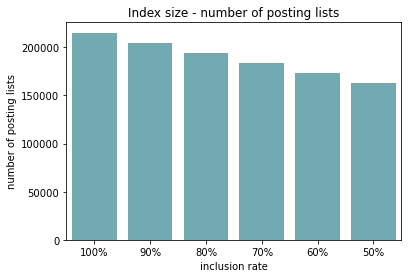

Summary_100%    215201
Summary_90%     204667
Summary_80%     194273
Summary_70%     183620
Summary_60%     173161
Summary_50%     162671
Name: Index size, dtype: object

In [9]:
# index size - number of posting lists
def compare_index_size(sizes, title):
    data = pd.to_numeric(sizes).to_list()
    plot_barchart(title, PLOT_X, data, 'inclusion rate', 'number of posting lists')

compare_index_size(summary.loc['Index size'], "Index size - number of posting lists")
summary.loc['Index size']

## Documnet list length comparison

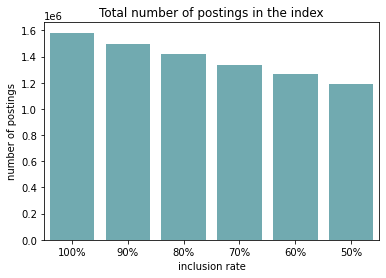

Total number of postings:


[1582263, 1496424, 1423118, 1335584, 1267326, 1188621]

In [10]:
freq_tables = results['termfreq']
posting_list_length_distribution = [table['posting_count'].value_counts().sort_index(inplace=False) for table in freq_tables]
total_posting_counts = [sum(table['posting_count']) for table in freq_tables]
plot_barchart('Total number of postings in the index', PLOT_X, total_posting_counts, 'inclusion rate', 'number of postings')
print('Total number of postings:')
total_posting_counts

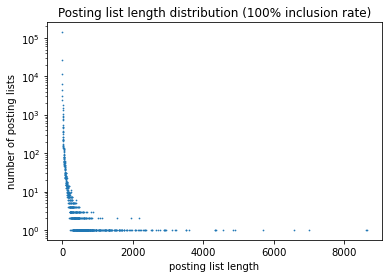

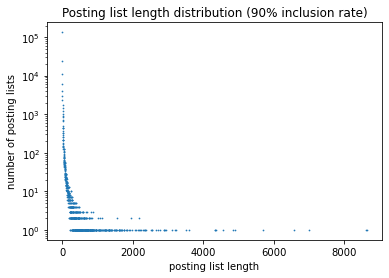

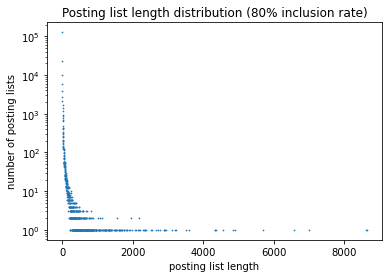

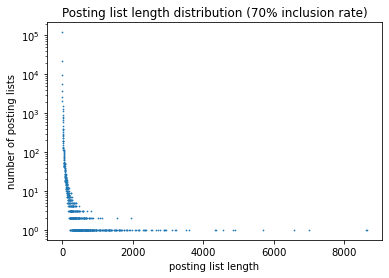

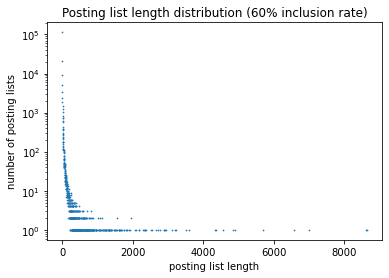

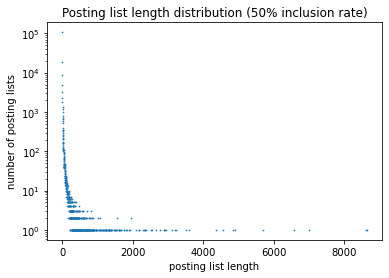

In [11]:
def compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution):
    for i in range(len(PLOT_X)):
        title = f'Posting list length distribution ({PLOT_X[i]} inclusion rate)'
        x = posting_list_length_distribution[i].index
        y = posting_list_length_distribution[i]
        plot_scatter(title, x, y, 'posting list length', 'number of posting lists', scale='log')   
compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution)

Average posting list length
[7.352489068359348, 7.311506007319206, 7.325351438439721, 7.273630323494173, 7.318772702860344, 7.306901660406588]


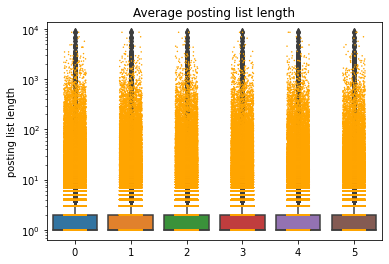

In [12]:
def compare_posting_list_len(PLOT_X, freq_tables):
    lengths = [table['posting_count'] for table in freq_tables]
    avgs = [sum(l)/len(l) for l in lengths]
    print("Average posting list length")
    print(avgs)
#     index15 = [int(round(len(l)*0.15,0)) for l in lengths]
#     index85 = [int(round(len(l)*0.85,0)) for l in lengths]
#     nooutlier_lengths = [ lengths[i][index15[i]:index85[i]] for i in range(len(lengths))]
    plot_boxplot(f'Average posting list length', lengths, 'posting list length', scale='log')
    
compare_posting_list_len(PLOT_X, freq_tables)

## Query Recall

In [13]:
query_result_similarity_lookup = results['query_result_similarity_lookup']
query_result_similarity_lookup

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Similarity_100%,Similarity_90%,Similarity_80%,Similarity_70%,Similarity_60%,Similarity_50%,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%
0,189567,189567,189567,189567,189567,189567,0.63636,0.700,0.700,0.700,0.700,0.55556,5137,4130,4130,4130,4130,2538
1,146028,146028,146028,146028,146028,-1,0.50000,0.600,0.600,0.500,0.500,0.00000,6516,5185,5185,4128,4128,-1
2,-1,-1,-1,145908,145908,145908,0.00000,0.000,0.000,0.500,0.500,0.50000,-1,-1,-1,1584,1584,1584
3,-1,-1,-1,-1,-1,-1,0.00000,0.000,0.000,0.000,0.000,0.00000,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,0.00000,0.000,0.000,0.000,0.000,0.00000,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21885,-1,-1,-1,-1,-1,-1,0.00000,0.000,0.000,0.000,0.000,0.00000,-1,-1,-1,-1,-1,-1
21886,-1,-1,-1,-1,-1,-1,0.00000,0.000,0.000,0.000,0.000,0.00000,-1,-1,-1,-1,-1,-1
21887,-1,-1,-1,-1,-1,-1,0.00000,0.000,0.000,0.000,0.000,0.00000,-1,-1,-1,-1,-1,-1
21888,-1,-1,-1,-1,-1,-1,0.00000,0.000,0.000,0.000,0.000,0.00000,-1,-1,-1,-1,-1,-1


In [14]:
has_true_similar = query_result_similarity_lookup[QUERY_RESULT_COL[0]] != -1
true_similar = query_result_similarity_lookup[has_true_similar]
num_true_similar = true_similar.shape[0]
true_similar

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Similarity_100%,Similarity_90%,Similarity_80%,Similarity_70%,Similarity_60%,Similarity_50%,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%
0,189567,189567,189567,189567,189567,189567,0.63636,0.70000,0.70000,0.70000,0.70000,0.55556,5137,4130,4130,4130,4130,2538
1,146028,146028,146028,146028,146028,-1,0.50000,0.60000,0.60000,0.50000,0.50000,0.00000,6516,5185,5185,4128,4128,-1
8,44802,44802,44802,44802,44802,44802,0.60000,0.60000,0.60000,0.60000,0.60000,0.60000,38975,38975,38975,38975,38975,38975
12,170152,170152,170152,197505,197505,197505,0.60000,0.60000,0.60000,0.50000,0.50000,0.50000,7605,7605,7605,20,20,20
15,102434,102434,102434,102434,102434,102434,0.50000,0.50000,0.50000,0.60000,0.60000,0.60000,10200,10200,10200,6940,6940,6940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21878,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,0.83333,0.60000,7,7,7,7,6,5
21880,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,0.83333,0.60000,7,7,7,7,6,5
21881,93654,93654,93654,93654,93654,93654,0.53846,0.53846,0.53846,0.53846,0.58333,0.58333,81484,81484,81484,81484,47616,47616
21884,178680,178680,178680,178680,178680,178680,0.62500,0.57143,0.57143,0.50000,0.50000,0.50000,120,84,84,66,66,66


In [15]:
num_correct_searches = []
correct_searches = []
for i in range(len(QUERY_RESULT_COL)):
    is_correct_search = true_similar[QUERY_RESULT_COL[0]] == true_similar[QUERY_RESULT_COL[i]]
    correct_search = true_similar[is_correct_search]
    correct_searches.append(correct_search)
    num_correct_searches.append(correct_search.shape[0])
print('Number of true similar tweets that we found: ')
num_correct_searches

Number of true similar tweets that we found: 


[7247, 6221, 5565, 4872, 4475, 3962]

Using 100% of terms, we can find 100.0% truly similar tweets
Using 90% of terms, we can find 85.84% truly similar tweets
Using 80% of terms, we can find 76.79% truly similar tweets
Using 70% of terms, we can find 67.23% truly similar tweets
Using 60% of terms, we can find 61.75% truly similar tweets
Using 50% of terms, we can find 54.67% truly similar tweets


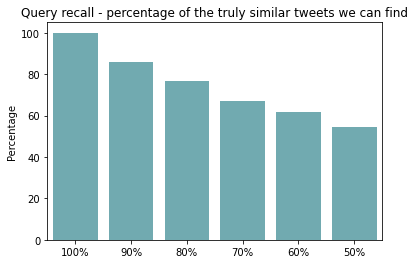

In [16]:
def compare_query_recall(recalls, title): 
    layer = sns.barplot(x=PLOT_X, y=recalls, color="#66B3BA")
    plt.title(title)
    layer.set(ylabel='Percentage')
    plt.show()

recalls = []
true_searches = []
for i in range(len(num_correct_searches)):
    true_searches.append(num_correct_searches[i])
    recall = round((num_correct_searches[i]/num_true_similar) * 100, 2)
    recalls.append(recall)
    chance = PLOT_X[i]
    print('Using {} of terms, we can find {}% truly similar tweets'.format(chance, recall))
    
compare_query_recall(recalls, 'Query recall - percentage of the truly similar tweets we can find')

## Query Precision

In [17]:
# is_predict_similar = query_result_similarity_lookup['Result_75%'] != -1
# predict_similar = query_result_similarity_lookup[is_predict_similar]
# num_predict_similar = predict_similar.shape[0]
# predict_similar
num_predict_similar_lst = []
predict_similar_lst = []
for i in range(len(QUERY_RESULT_COL)):
    is_predict_similar = query_result_similarity_lookup[QUERY_RESULT_COL[i]] != -1
    predict_similar = query_result_similarity_lookup[is_predict_similar]
    predict_similar_lst.append(predict_similar)
    num_predict_similar_lst.append(predict_similar.shape[0])
print("The number of tweets that we think are similar: ")
num_predict_similar_lst

The number of tweets that we think are similar: 


[7247, 7384, 7530, 7594, 7673, 7597]

Using 100% of terms, 100.0% tweets that we found similar are truly similar tweets
Using 90% of terms, 84.25% tweets that we found similar are truly similar tweets
Using 80% of terms, 73.9% tweets that we found similar are truly similar tweets
Using 70% of terms, 64.16% tweets that we found similar are truly similar tweets
Using 60% of terms, 58.32% tweets that we found similar are truly similar tweets
Using 50% of terms, 52.15% tweets that we found similar are truly similar tweets


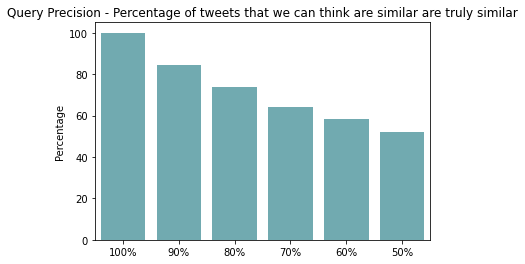

In [18]:
def compare_query_precision(precisions, title): 
    layer = sns.barplot(x=PLOT_X, y=precisions, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

precisions = []
for i in range(len(num_predict_similar_lst)):
    precision = round((num_correct_searches[i]/num_predict_similar_lst[i]) * 100, 2)
    precisions.append(precision)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% tweets that we found similar are truly similar tweets'.format(chance, precision))
    
compare_query_precision(precisions, 'Query Precision - Percentage of tweets that we can think are similar are truly similar')

## Number of searches that need fewer lookups

In [19]:
correct_search

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Similarity_100%,Similarity_90%,Similarity_80%,Similarity_70%,Similarity_60%,Similarity_50%,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%
0,189567,189567,189567,189567,189567,189567,0.63636,0.70000,0.70000,0.70000,0.70000,0.55556,5137,4130,4130,4130,4130,2538
8,44802,44802,44802,44802,44802,44802,0.60000,0.60000,0.60000,0.60000,0.60000,0.60000,38975,38975,38975,38975,38975,38975
15,102434,102434,102434,102434,102434,102434,0.50000,0.50000,0.50000,0.60000,0.60000,0.60000,10200,10200,10200,6940,6940,6940
34,193795,193795,193795,193795,193795,193795,0.60000,0.50000,0.50000,0.50000,0.50000,0.50000,365,112,112,112,112,112
40,708,708,708,708,708,708,1.00000,1.00000,1.00000,1.00000,1.00000,0.80000,12438,12438,12438,12438,12438,9260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21878,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,0.83333,0.60000,7,7,7,7,6,5
21880,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,0.83333,0.60000,7,7,7,7,6,5
21881,93654,93654,93654,93654,93654,93654,0.53846,0.53846,0.53846,0.53846,0.58333,0.58333,81484,81484,81484,81484,47616,47616
21884,178680,178680,178680,178680,178680,178680,0.62500,0.57143,0.57143,0.50000,0.50000,0.50000,120,84,84,66,66,66


In [20]:
query_of_less_lookups = []
less_search_lst = []
for i in range(len(QUERY_LOOKUPS_COL)):
    if i != 0:
        is_less_search = correct_searches[i][QUERY_LOOKUPS_COL[0]] > correct_searches[i][QUERY_LOOKUPS_COL[i]]
        less_search = correct_searches[i][is_less_search]
        less_search_lst.append(less_search)
        query_of_less_lookups.append(less_search.shape[0])
    else:
        less_search_lst.append(None)
        query_of_less_lookups.append(0)
print("The number of tweets that need less lookups before correctly finding the true similar tweets: ")
query_of_less_lookups

The number of tweets that need less lookups before correctly finding the true similar tweets: 


[0, 1394, 2153, 2583, 2759, 2779]

Using 100% of terms, 0.0% queries need less lookups before correctly finding the true similar tweets
Using 90% of terms, 22.41% queries need less lookups before correctly finding the true similar tweets
Using 80% of terms, 38.69% queries need less lookups before correctly finding the true similar tweets
Using 70% of terms, 53.02% queries need less lookups before correctly finding the true similar tweets
Using 60% of terms, 61.65% queries need less lookups before correctly finding the true similar tweets
Using 50% of terms, 70.14% queries need less lookups before correctly finding the true similar tweets


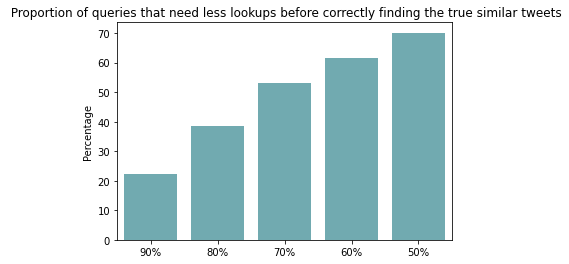

In [21]:
def compare_number_of_tweets_need_less_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X[1:], y=reduces, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

proportions = []
for i in range(len(query_of_less_lookups)):
    proportion = round((query_of_less_lookups[i] / num_correct_searches[i]) * 100, 2)
    proportions.append(proportion)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% queries need less lookups before correctly finding the true similar tweets'.format(chance, proportion))
    
compare_number_of_tweets_need_less_lookups(proportions[1:], ' Proportion of queries that need less lookups before correctly finding the true similar tweets')

## Number of average lookups

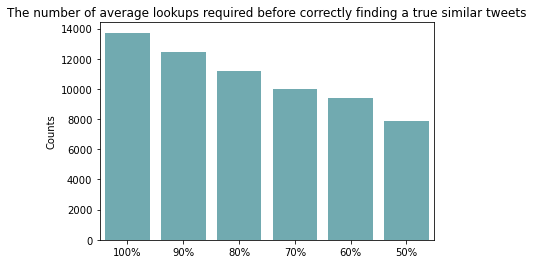

In [22]:
def compare_number_of_avg_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X, y=reduces, color="#66B3BA")
    layer.set(ylabel='Counts')
    plt.title(title)
    plt.show()

avg_lookups = []
for i in range(len(QUERY_LOOKUPS_COL)):
    avg_lookup = np.average(np.array(correct_searches[i][QUERY_LOOKUPS_COL[i]]))
    avg_lookups.append(avg_lookup)

compare_number_of_avg_lookups(avg_lookups, 'The number of average lookups required before correctly finding a true similar tweets')

In [23]:
reduces = []
print('Comparing to using all the terms:')
for i in range(len(avg_lookups)):
    if i != 0:
        reduce = round(((avg_lookups[0] - avg_lookups[i]) / avg_lookups[0]) * 100, 2)
        reduces.append(reduce)
        chance = PLOT_X[i]
        print('By using {} of terms, {}% of less lookups are needed for correctly finding a true similar tweets'.format(chance, reduce))

Comparing to using all the terms:
By using 90% of terms, 9.47% of less lookups are needed for correctly finding a true similar tweets
By using 80% of terms, 18.26% of less lookups are needed for correctly finding a true similar tweets
By using 70% of terms, 27.18% of less lookups are needed for correctly finding a true similar tweets
By using 60% of terms, 31.54% of less lookups are needed for correctly finding a true similar tweets
By using 50% of terms, 42.58% of less lookups are needed for correctly finding a true similar tweets


## Index time comparison

In [24]:
index_time = results['index_time']
index_time

,Index_time_run1_100%,Index_time_run2_100%,Index_time_run3_100%,Index_time_run1_90%,Index_time_run2_90%,Index_time_run3_90%,Index_time_run1_80%,Index_time_run2_80%,Index_time_run3_80%,Index_time_run1_70%,Index_time_run2_70%,Index_time_run3_70%,Index_time_run1_60%,Index_time_run2_60%,Index_time_run3_60%,Index_time_run1_50%,Index_time_run2_50%,Index_time_run3_50%
0,10.3842,11.2074,10.2378,17.3480,19.3493,17.4524,20.3142,16.0656,15.9021,17.5591,19.4509,17.4906,18.1446,16.1685,16.2634,18.4739,21.3837,15.9200
1,4.0851,4.8221,4.5322,7.4903,8.0840,6.7924,7.7650,6.2719,5.5233,7.0042,7.9939,8.4024,6.4088,6.9230,6.0271,8.1421,8.2292,5.9576
2,4.5891,4.6203,4.3922,7.5490,7.7049,7.0115,6.9672,6.4025,5.3988,6.5760,6.4777,6.6584,6.4995,6.5555,5.7542,6.4897,6.7008,5.4973
3,4.1641,4.7461,4.3905,7.7446,6.6661,5.9527,6.2212,5.4852,5.2755,6.6455,6.0281,6.8210,6.5120,6.4588,5.9075,6.4402,6.1049,5.8476
4,4.1315,4.8563,4.3739,6.6703,6.8666,6.5180,6.7494,6.1652,5.5565,6.5313,8.0097,5.3585,6.5329,6.5536,5.6799,6.4075,6.2484,5.5448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,2.1698,2.3807,2.5827,3.9226,3.9420,4.1292,3.6894,5.9725,3.8819,3.3205,4.1148,3.6192,4.1550,5.1200,3.3315,3.5791,3.5002,3.7773
193,2.2688,2.0851,2.5433,4.3118,4.0477,4.3086,3.5517,5.6326,3.8758,18.7127,4.0653,3.5440,3.4363,4.1078,16.0598,3.7287,3.4467,3.3945
194,2.0247,2.0789,2.5444,4.3080,4.1104,4.1070,3.8990,5.9178,4.0564,3.7108,4.1943,3.7262,3.4276,4.3588,3.3491,3.6881,3.3938,3.4733
195,1.9793,1.9621,2.4350,3.6102,4.0710,3.6792,3.4641,5.5140,3.5213,3.4622,3.9238,3.5669,16.6496,19.7804,3.1322,3.4212,3.2378,3.3482


By using 100% of terms, the average time for indexing 1000 tweets is 3.1453 milliseconds
By using 90% of terms, the average time for indexing 1000 tweets is 4.5057 milliseconds
By using 80% of terms, the average time for indexing 1000 tweets is 4.3714 milliseconds
By using 70% of terms, the average time for indexing 1000 tweets is 4.1869 milliseconds
By using 60% of terms, the average time for indexing 1000 tweets is 4.1325 milliseconds
By using 50% of terms, the average time for indexing 1000 tweets is 4.2749 milliseconds


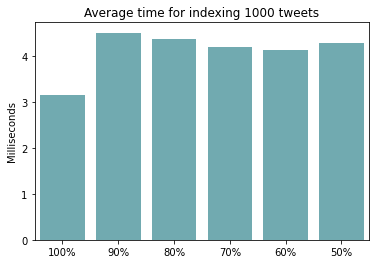

In [25]:
def compare_time(avg_time, title): 
    layer = sns.barplot(x=PLOT_X, y=avg_time, color="#66B3BA")
    layer.set(ylabel='Milliseconds')
    plt.title(title)
    plt.show()

index_time_avgs = []
for col in index_time.columns:
    index_time_avgs.append(np.average(np.array(index_time[col])))

index_time_avgs2 = []
c = 0
acc = 0
for avg in index_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        index_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(index_time_avgs2)):
    print('By using {} of terms, the average time for indexing {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, index_time_avgs2[i]))
compare_time(index_time_avgs2, 'Average time for indexing {} tweets'.format(INDEX_TIME_UNIT))

## Query time comparison

In [26]:
query_time = results['query_time']
query_time

,Query_time_run1_100%,Query_time_run2_100%,Query_time_run3_100%,Query_time_run1_90%,Query_time_run2_90%,Query_time_run3_90%,Query_time_run1_80%,Query_time_run2_80%,Query_time_run3_80%,Query_time_run1_70%,Query_time_run2_70%,Query_time_run3_70%,Query_time_run1_60%,Query_time_run2_60%,Query_time_run3_60%,Query_time_run1_50%,Query_time_run2_50%,Query_time_run3_50%
0,2.5254,2.7025,2.6527,3.0990,2.3012,3.7418,2.2840,2.9383,2.0673,2.0999,3.2592,2.4197,2.9402,2.3079,2.1969,1.9300,2.5303,1.7515
1,331.7666,366.8047,268.7204,297.6608,283.5613,293.8549,263.7315,285.8928,245.1286,234.8505,238.6947,200.4594,192.4825,201.6140,188.8501,168.7949,184.0902,213.4162
2,182.4507,203.3716,177.4221,192.5939,178.3240,189.0200,163.1331,168.9143,163.0688,120.6391,134.7871,120.6827,107.0682,114.0663,100.9650,89.7278,95.9796,93.6023
3,192.0488,201.8154,182.9131,193.8457,190.7914,208.2252,167.6932,176.4356,158.5608,122.8300,143.1851,125.5000,121.2761,114.0173,102.0486,93.9836,103.4157,96.6776
4,193.6234,208.3532,190.6546,205.8471,218.9580,215.0236,182.9205,177.6237,170.4256,128.1036,144.2312,127.9845,123.4764,119.5095,107.2475,101.8538,105.3646,97.8408
5,172.6752,208.5647,186.4154,202.7830,205.0516,216.4221,182.0871,169.9258,172.2572,134.7001,148.7614,134.0892,121.3626,137.0565,110.6359,104.7168,123.1273,103.4277
6,183.5003,194.2543,187.1050,192.1565,178.3946,201.2131,171.5646,159.7348,160.2356,122.1347,149.9611,128.0575,116.8605,134.7427,103.8297,106.5005,111.9637,97.2074
7,189.6462,196.6967,190.5630,203.9591,185.3302,213.1641,174.8977,181.7722,173.4695,133.0784,166.3157,138.0239,130.8600,121.2826,106.9717,113.8780,120.6681,104.4731
8,190.4970,212.2757,186.2100,207.1279,186.2285,216.2474,164.3680,186.3576,166.9166,126.5220,141.9644,122.9511,116.3776,115.6550,106.3303,102.7766,108.9253,106.8098
9,173.2336,181.3586,171.8741,189.8233,173.4676,201.3206,159.9113,236.3741,159.6663,129.2291,136.1257,129.8001,115.1158,117.6029,109.9077,101.9144,108.1036,103.4663


By using 100% of terms, the average time for querying 1000 tweets is 177.2072 milliseconds
By using 90% of terms, the average time for querying 1000 tweets is 184.7571 milliseconds
By using 80% of terms, the average time for querying 1000 tweets is 161.625 milliseconds
By using 70% of terms, the average time for querying 1000 tweets is 122.3678 milliseconds
By using 60% of terms, the average time for querying 1000 tweets is 105.827 milliseconds
By using 50% of terms, the average time for querying 1000 tweets is 96.1259 milliseconds


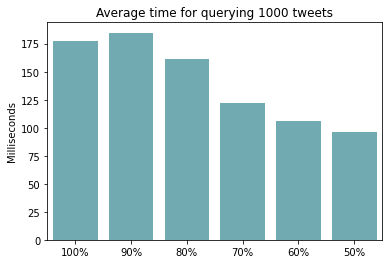

In [27]:
query_time_avgs = []
for col in query_time.columns:
    query_time_avgs.append(np.average(np.array(query_time[col])))

query_time_avgs2 = []
c = 0
acc = 0
for avg in query_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        query_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(query_time_avgs2)):
    print('By using {} of terms, the average time for querying {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, query_time_avgs2[i]))
compare_time(query_time_avgs2, 'Average time for querying {} tweets'.format(INDEX_TIME_UNIT))